In [1]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
train_df = pd.read_csv('train_1.csv').fillna(0)
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [4]:
#Simple Regex code to get language of any given page
def find_language(url):
    res = re.search('[a-z][a-z].wikipedia.org',url)
    if res:
        return res[0][0:2]
    return 'na'

train_df['lang'] = train_df.Page.map(find_language)

In [5]:
#Here we separate all the pages based on their language and average them up to find views per page per language
lang_sets = {}
lang_sets['en'] = train_df[train_df.lang=='en'].iloc[:,0:-1] #iloc [l1:l2] l1- rows and l2- columns
lang_sets['ja'] = train_df[train_df.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train_df[train_df.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train_df[train_df.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train_df[train_df.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train_df[train_df.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train_df[train_df.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train_df[train_df.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets.keys(): # can also use lang_sets in for loop to get keys
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]  #sum(axis=?): 0 then across columns, 1 then across rows

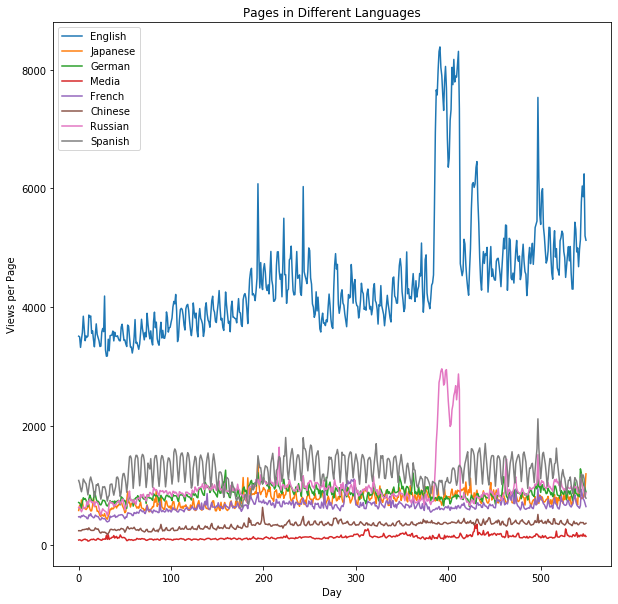

In [6]:
#Plots of avg # of views for all different languages per day
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

In [7]:
time = sums['en'].index
series = sums['en'].values

In [8]:
split = 400
train = series[:split]
test = series[split:]

We have a univariant sequence:
- We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned.

[10, 20, 30, 40, 50, 60, 70, 80, 90]

X,-------------- y\
10, 20, 30------40 \
20, 30, 40------50 \
30, 40, 50------60

In [9]:

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [35]:
n_steps = 10
train_X, train_y = split_sequence(train, n_steps)
test_X, test_y = split_sequence(test,n_steps)
X,y = split_sequence(series,n_steps)

### Input transformation
- n_steps = 3 and n_features = 1 (univariant)
The shape of the input for each sample is specified in the input_shape argument on the definition of first hidden layer.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape:

[samples, timesteps, features]

In [38]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
X = X.reshape((X.shape[0], X.shape[1], n_features))

### Vanilla LSTM 
In this case, we define a model with 50 LSTM units in the hidden layer and an output layer that predicts a single numerical value.

The model is fit using the efficient Adam version of stochastic gradient descent and optimized using the mean squared error, or ‘mse‘ loss function.

In [12]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.fit(X,y,epochs=200,verbose=1)

Train on 547 samples
Epoch 1/200
547/547 [==============================] - 1s 2ms/sample - loss: 23008425.6563 - mae: 4686.2808
Epoch 2/200
547/547 [==============================] - 0s 151us/sample - loss: 20129399.9433 - mae: 4380.6792
Epoch 3/200
547/547 [==============================] - 0s 141us/sample - loss: 16408619.0622 - mae: 3953.4539
Epoch 4/200
547/547 [==============================] - 0s 133us/sample - loss: 11372724.0576 - mae: 3278.7241
Epoch 5/200
547/547 [==============================] - 0s 157us/sample - loss: 5555403.8304 - mae: 2259.2759
Epoch 6/200
547/547 [==============================] - 0s 141us/sample - loss: 1401608.9437 - mae: 1052.4456
Epoch 7/200
547/547 [==============================] - 0s 183us/sample - loss: 232417.2290 - mae: 342.0014
Epoch 8/200
547/547 [==============================] - 0s 168us/sample - loss: 175968.3526 - mae: 298.6314
Epoch 9/200
547/547 [==============================] - 0s 168us/sample - loss: 162328.4991 - mae: 279.6179
Ep

547/547 [==============================] - 0s 166us/sample - loss: 189378.2418 - mae: 310.2188
Epoch 77/200
547/547 [==============================] - 0s 144us/sample - loss: 168160.3619 - mae: 287.5576
Epoch 78/200
547/547 [==============================] - 0s 150us/sample - loss: 158018.2513 - mae: 281.7558
Epoch 79/200
547/547 [==============================] - 0s 157us/sample - loss: 154087.7075 - mae: 276.2939
Epoch 80/200
547/547 [==============================] - 0s 155us/sample - loss: 154160.9045 - mae: 278.7270
Epoch 81/200
547/547 [==============================] - 0s 152us/sample - loss: 148064.3716 - mae: 269.6571
Epoch 82/200
547/547 [==============================] - 0s 143us/sample - loss: 164630.8249 - mae: 284.7520
Epoch 83/200
547/547 [==============================] - 0s 150us/sample - loss: 145085.7886 - mae: 268.3613
Epoch 84/200
547/547 [==============================] - 0s 161us/sample - loss: 138575.7157 - mae: 260.2279
Epoch 85/200
547/547 [===================

547/547 [==============================] - 0s 148us/sample - loss: 155350.1873 - mae: 276.7270
Epoch 152/200
547/547 [==============================] - 0s 197us/sample - loss: 157315.4582 - mae: 276.1407
Epoch 153/200
547/547 [==============================] - 0s 139us/sample - loss: 154118.9984 - mae: 277.4289
Epoch 154/200
547/547 [==============================] - 0s 144us/sample - loss: 154333.1967 - mae: 275.9078
Epoch 155/200
547/547 [==============================] - 0s 150us/sample - loss: 154002.5144 - mae: 276.7744
Epoch 156/200
547/547 [==============================] - 0s 130us/sample - loss: 152819.6005 - mae: 273.3698
Epoch 157/200
547/547 [==============================] - 0s 159us/sample - loss: 153957.1957 - mae: 277.6133
Epoch 158/200
547/547 [==============================] - 0s 161us/sample - loss: 154758.2376 - mae: 279.3177
Epoch 159/200
547/547 [==============================] - 0s 141us/sample - loss: 151954.8837 - mae: 272.5918
Epoch 160/200
547/547 [==========

### Stacked LSTM

Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as an interpretation from the end of the sequence.

We can address this by having the LSTM output a value for each time step in the input data by setting the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next

In [54]:
tf.random.set_seed(51)
np.random.seed(51)
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.LSTM(50,return_sequences=True, activation='relu', input_shape=(n_steps, n_features)))
model1.add(tf.keras.layers.LSTM(50,activation='relu'))
model1.add(tf.keras.layers.Dense(1))
model1.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [55]:
model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 5, 50)             10400     
_________________________________________________________________
lstm_47 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [56]:
model1.fit(X,y,epochs=200,verbose=1)

Train on 545 samples
Epoch 1/200
545/545 [==============================] - 2s 4ms/sample - loss: 17881080.4147 - mae: 4126.6499
Epoch 2/200
545/545 [==============================] - 0s 262us/sample - loss: 11864841.0339 - mae: 3341.4221
Epoch 3/200
545/545 [==============================] - 0s 262us/sample - loss: 5362864.3880 - mae: 2191.3201
Epoch 4/200
545/545 [==============================] - 0s 264us/sample - loss: 417273.6575 - mae: 457.8037
Epoch 5/200
545/545 [==============================] - 0s 261us/sample - loss: 300742.4513 - mae: 375.1129
Epoch 6/200
545/545 [==============================] - 0s 255us/sample - loss: 267579.6044 - mae: 343.6438
Epoch 7/200
545/545 [==============================] - 0s 253us/sample - loss: 251635.7847 - mae: 337.1335
Epoch 8/200
545/545 [==============================] - 0s 246us/sample - loss: 265674.9411 - mae: 348.7826
Epoch 9/200
545/545 [==============================] - 0s 262us/sample - loss: 252061.5084 - mae: 336.5244
Epoch 10/2

545/545 [==============================] - 0s 244us/sample - loss: 203669.0007 - mae: 304.3569
Epoch 77/200
545/545 [==============================] - 0s 240us/sample - loss: 198966.6186 - mae: 298.2514
Epoch 78/200
545/545 [==============================] - 0s 251us/sample - loss: 205738.9207 - mae: 297.0454
Epoch 79/200
545/545 [==============================] - 0s 259us/sample - loss: 205534.2452 - mae: 293.7957
Epoch 80/200
545/545 [==============================] - 0s 244us/sample - loss: 230143.0497 - mae: 318.0725
Epoch 81/200
545/545 [==============================] - 0s 244us/sample - loss: 217162.6950 - mae: 308.5987
Epoch 82/200
545/545 [==============================] - 0s 261us/sample - loss: 230975.9676 - mae: 323.7553
Epoch 83/200
545/545 [==============================] - 0s 244us/sample - loss: 211151.1671 - mae: 303.2890
Epoch 84/200
545/545 [==============================] - 0s 244us/sample - loss: 208216.2544 - mae: 301.1662
Epoch 85/200
545/545 [===================

545/545 [==============================] - 0s 270us/sample - loss: 187485.6868 - mae: 297.3404
Epoch 151/200
545/545 [==============================] - 0s 257us/sample - loss: 184360.3018 - mae: 296.4641
Epoch 152/200
545/545 [==============================] - 0s 270us/sample - loss: 189191.6428 - mae: 300.0076
Epoch 153/200
545/545 [==============================] - 0s 255us/sample - loss: 186450.4974 - mae: 297.6537
Epoch 154/200
545/545 [==============================] - 0s 279us/sample - loss: 200105.0368 - mae: 313.9002
Epoch 155/200
545/545 [==============================] - 0s 272us/sample - loss: 184343.4293 - mae: 296.8202
Epoch 156/200
545/545 [==============================] - 0s 268us/sample - loss: 185977.4528 - mae: 298.0765
Epoch 157/200
545/545 [==============================] - 0s 259us/sample - loss: 183254.1467 - mae: 295.4366
Epoch 158/200
545/545 [==============================] - 0s 273us/sample - loss: 179304.6610 - mae: 293.3308
Epoch 159/200
545/545 [==========

### Bi-directional LSTM
On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and concatenate both interpretations.

This is called a Bidirectional LSTM.

tf.random.set_seed(51)
np.random.seed(51)We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping the first hidden layer in a wrapper layer called Bidirectional.

In [18]:

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model2.add(tf.keras.layers.Dense(1))
model2.compile(optimizer='adam', loss='mse',metrics=['mae'])

In [19]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [20]:
model2.fit(X,y,epochs=200,verbose=1)

Train on 547 samples
Epoch 1/200
547/547 [==============================] - 2s 4ms/sample - loss: 16935121.1243 - mae: 4003.5471
Epoch 2/200
547/547 [==============================] - 0s 185us/sample - loss: 10094289.2011 - mae: 3080.6926
Epoch 3/200
547/547 [==============================] - 0s 192us/sample - loss: 4119242.6570 - mae: 1930.6986
Epoch 4/200
547/547 [==============================] - 0s 218us/sample - loss: 906479.9556 - mae: 770.9146
Epoch 5/200
547/547 [==============================] - 0s 218us/sample - loss: 161202.5714 - mae: 290.8132
Epoch 6/200
547/547 [==============================] - 0s 214us/sample - loss: 158888.7446 - mae: 284.5211
Epoch 7/200
547/547 [==============================] - 0s 199us/sample - loss: 150135.3229 - mae: 271.5212
Epoch 8/200
547/547 [==============================] - 0s 202us/sample - loss: 149567.2631 - mae: 270.8251
Epoch 9/200
547/547 [==============================] - 0s 207us/sample - loss: 150875.2405 - mae: 272.6562
Epoch 10/2

547/547 [==============================] - 0s 207us/sample - loss: 150128.5625 - mae: 271.6848
Epoch 77/200
547/547 [==============================] - 0s 214us/sample - loss: 149987.1958 - mae: 278.0336
Epoch 78/200
547/547 [==============================] - 0s 201us/sample - loss: 149223.8828 - mae: 269.9091
Epoch 79/200
547/547 [==============================] - 0s 201us/sample - loss: 146124.4016 - mae: 270.9469
Epoch 80/200
547/547 [==============================] - 0s 227us/sample - loss: 146034.9665 - mae: 270.0823
Epoch 81/200
547/547 [==============================] - 0s 197us/sample - loss: 147388.1141 - mae: 268.3842
Epoch 82/200
547/547 [==============================] - 0s 221us/sample - loss: 146774.5429 - mae: 271.8059
Epoch 83/200
547/547 [==============================] - 0s 219us/sample - loss: 146566.0652 - mae: 268.3519
Epoch 84/200
547/547 [==============================] - 0s 199us/sample - loss: 147297.3892 - mae: 271.7935
Epoch 85/200
547/547 [===================

547/547 [==============================] - 0s 218us/sample - loss: 143790.2872 - mae: 265.8346
Epoch 152/200
547/547 [==============================] - 0s 223us/sample - loss: 136995.0810 - mae: 261.1417
Epoch 153/200
547/547 [==============================] - 0s 194us/sample - loss: 137722.5707 - mae: 262.4414
Epoch 154/200
547/547 [==============================] - 0s 190us/sample - loss: 140659.6436 - mae: 263.9100
Epoch 155/200
547/547 [==============================] - 0s 208us/sample - loss: 139377.0216 - mae: 263.9026
Epoch 156/200
547/547 [==============================] - 0s 219us/sample - loss: 137299.7054 - mae: 259.5910
Epoch 157/200
547/547 [==============================] - 0s 197us/sample - loss: 138988.3452 - mae: 260.3279
Epoch 158/200
547/547 [==============================] - 0s 195us/sample - loss: 142925.6944 - mae: 267.9827
Epoch 159/200
547/547 [==============================] - 0s 194us/sample - loss: 137788.3751 - mae: 264.6743
Epoch 160/200
547/547 [==========

In [40]:
n_steps = 5
train_X, train_y = split_sequence(train, n_steps)
test_X, test_y = split_sequence(test,n_steps)
X,y = split_sequence(series,n_steps)

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [62]:
tf.random.set_seed(51)
np.random.seed(51)
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('mae')<150):
              print("\nReached desired performance cancelling training!")
              self.model.stop_training = True

model2 = tf.keras.models.Sequential()
#model2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu',return_sequences=True), input_shape=(n_steps, n_features)))
model2.add(tf.keras.layers.LSTM(50,return_sequences=True, activation='relu', input_shape=(n_steps, n_features)))
#model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.LSTM(50,activation='relu',return_sequences=True))
#model2.add(tf.keras.layers.LSTM(20,activation='relu',return_sequences=True))
model2.add(tf.keras.layers.LSTM(50,activation='relu'))
#model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(1))
callback = myCallback()
model2.compile(optimizer='adam', loss='mse',metrics=['mae'])

model2.fit(train_X,train_y,epochs=500,verbose=1,callbacks=[callback],validation_data=(test_X, test_y))

Train on 395 samples, validate on 145 samples
Epoch 1/500
395/395 [==============================] - 3s 8ms/sample - loss: 17239454.1873 - mae: 4072.2229 - val_loss: 24775364.0414 - val_mae: 4909.4092
Epoch 2/500
395/395 [==============================] - 0s 479us/sample - loss: 15378987.8430 - mae: 3844.4500 - val_loss: 20928774.4276 - val_mae: 4507.0205
Epoch 3/500
395/395 [==============================] - 0s 458us/sample - loss: 11706156.9051 - mae: 3339.9260 - val_loss: 11255869.1241 - val_mae: 3283.2742
Epoch 4/500
395/395 [==============================] - 0s 430us/sample - loss: 3067617.5546 - mae: 1463.6362 - val_loss: 763723.5459 - val_mae: 616.8812
Epoch 5/500
395/395 [==============================] - 0s 432us/sample - loss: 448979.6196 - mae: 527.5916 - val_loss: 651820.3700 - val_mae: 541.3165
Epoch 6/500
395/395 [==============================] - 0s 456us/sample - loss: 242938.8762 - mae: 318.3012 - val_loss: 609617.7537 - val_mae: 533.8109
Epoch 7/500
395/395 [=========

395/395 [==============================] - 0s 413us/sample - loss: 203527.4919 - mae: 297.8162 - val_loss: 567018.4877 - val_mae: 506.5771
Epoch 55/500
395/395 [==============================] - 0s 405us/sample - loss: 207386.0386 - mae: 299.2380 - val_loss: 589986.4026 - val_mae: 511.0250
Epoch 56/500
395/395 [==============================] - 0s 398us/sample - loss: 218562.9389 - mae: 305.6855 - val_loss: 702696.7237 - val_mae: 559.1652
Epoch 57/500
395/395 [==============================] - 0s 415us/sample - loss: 208369.7063 - mae: 297.9333 - val_loss: 567252.2461 - val_mae: 502.0365
Epoch 58/500
395/395 [==============================] - 0s 403us/sample - loss: 197233.7406 - mae: 291.0489 - val_loss: 557578.3539 - val_mae: 498.1462
Epoch 59/500
395/395 [==============================] - 0s 405us/sample - loss: 198175.6553 - mae: 295.3314 - val_loss: 554452.1724 - val_mae: 503.1860
Epoch 60/500
395/395 [==============================] - 0s 418us/sample - loss: 209514.6333 - mae: 30

Epoch 108/500
395/395 [==============================] - 0s 401us/sample - loss: 187275.5778 - mae: 296.0769 - val_loss: 504598.4162 - val_mae: 485.3374
Epoch 109/500
395/395 [==============================] - 0s 442us/sample - loss: 189007.1081 - mae: 298.8337 - val_loss: 536979.3817 - val_mae: 488.9331
Epoch 110/500
395/395 [==============================] - 0s 514us/sample - loss: 190615.4120 - mae: 293.4487 - val_loss: 545330.8373 - val_mae: 491.8217
Epoch 111/500
395/395 [==============================] - 0s 448us/sample - loss: 183863.0560 - mae: 291.9202 - val_loss: 498383.9334 - val_mae: 484.2906
Epoch 112/500
395/395 [==============================] - 0s 436us/sample - loss: 186881.9652 - mae: 295.4356 - val_loss: 520716.7030 - val_mae: 483.1365
Epoch 113/500
395/395 [==============================] - 0s 433us/sample - loss: 184421.7739 - mae: 288.9598 - val_loss: 518149.9002 - val_mae: 482.1440
Epoch 114/500
395/395 [==============================] - 0s 443us/sample - loss: 1

395/395 [==============================] - 0s 425us/sample - loss: 158012.3772 - mae: 277.1484 - val_loss: 422810.8961 - val_mae: 438.6482
Epoch 162/500
395/395 [==============================] - 0s 438us/sample - loss: 155098.1491 - mae: 271.4007 - val_loss: 412325.5705 - val_mae: 439.3245
Epoch 163/500
395/395 [==============================] - 0s 428us/sample - loss: 162521.3234 - mae: 278.2399 - val_loss: 430781.5819 - val_mae: 439.5222
Epoch 164/500
395/395 [==============================] - 0s 516us/sample - loss: 155181.8186 - mae: 271.3024 - val_loss: 418493.9731 - val_mae: 435.8651
Epoch 165/500
395/395 [==============================] - 0s 836us/sample - loss: 154895.7599 - mae: 274.9287 - val_loss: 442897.4032 - val_mae: 444.9080
Epoch 166/500
395/395 [==============================] - 0s 509us/sample - loss: 152700.6885 - mae: 271.6369 - val_loss: 402671.1763 - val_mae: 437.8174
Epoch 167/500
395/395 [==============================] - 0s 446us/sample - loss: 158355.5273 - m

395/395 [==============================] - 0s 509us/sample - loss: 125937.8915 - mae: 249.4066 - val_loss: 330830.4491 - val_mae: 392.2882
Epoch 215/500
395/395 [==============================] - 0s 440us/sample - loss: 130836.1239 - mae: 255.8330 - val_loss: 325883.4543 - val_mae: 391.3988
Epoch 216/500
395/395 [==============================] - 0s 456us/sample - loss: 133039.9480 - mae: 258.0642 - val_loss: 322360.3834 - val_mae: 400.0805
Epoch 217/500
395/395 [==============================] - 0s 451us/sample - loss: 124069.8531 - mae: 250.4594 - val_loss: 327401.2048 - val_mae: 389.5443
Epoch 218/500
395/395 [==============================] - 0s 410us/sample - loss: 143129.4457 - mae: 272.4267 - val_loss: 347240.8017 - val_mae: 431.2833
Epoch 219/500
395/395 [==============================] - 0s 407us/sample - loss: 146314.7769 - mae: 268.0618 - val_loss: 324546.7022 - val_mae: 407.3852
Epoch 220/500
395/395 [==============================] - 0s 466us/sample - loss: 130357.7784 - m

395/395 [==============================] - 0s 385us/sample - loss: 102449.7850 - mae: 227.0428 - val_loss: 294540.4683 - val_mae: 360.2475
Epoch 268/500
395/395 [==============================] - 0s 399us/sample - loss: 105890.3506 - mae: 235.6428 - val_loss: 298738.7976 - val_mae: 361.8481
Epoch 269/500
395/395 [==============================] - 0s 390us/sample - loss: 105096.3988 - mae: 232.5186 - val_loss: 257964.2374 - val_mae: 352.0269
Epoch 270/500
395/395 [==============================] - 0s 388us/sample - loss: 102342.1784 - mae: 234.2273 - val_loss: 258840.3853 - val_mae: 358.2462
Epoch 271/500
395/395 [==============================] - 0s 389us/sample - loss: 107059.1299 - mae: 235.6975 - val_loss: 259097.6828 - val_mae: 359.4840
Epoch 272/500
395/395 [==============================] - 0s 386us/sample - loss: 105972.7044 - mae: 236.8701 - val_loss: 259575.9922 - val_mae: 361.2290
Epoch 273/500
395/395 [==============================] - 0s 400us/sample - loss: 106987.9036 - m

Epoch 321/500
395/395 [==============================] - 0s 436us/sample - loss: 92235.7646 - mae: 212.5603 - val_loss: 233659.9130 - val_mae: 322.4621
Epoch 322/500
395/395 [==============================] - 0s 443us/sample - loss: 89903.6102 - mae: 211.3567 - val_loss: 231317.5079 - val_mae: 322.1911
Epoch 323/500
395/395 [==============================] - 0s 420us/sample - loss: 89248.1709 - mae: 214.5033 - val_loss: 226116.9519 - val_mae: 333.4357
Epoch 324/500
395/395 [==============================] - 0s 435us/sample - loss: 92389.9769 - mae: 215.0849 - val_loss: 224011.1387 - val_mae: 328.0533
Epoch 325/500
395/395 [==============================] - 0s 428us/sample - loss: 94053.2987 - mae: 217.2314 - val_loss: 224944.5282 - val_mae: 322.3723
Epoch 326/500
395/395 [==============================] - 0s 428us/sample - loss: 90307.6858 - mae: 215.4770 - val_loss: 224043.3664 - val_mae: 322.1501
Epoch 327/500
395/395 [==============================] - 0s 415us/sample - loss: 89217.4

Epoch 375/500
395/395 [==============================] - 0s 382us/sample - loss: 86943.1325 - mae: 204.3604 - val_loss: 230382.4383 - val_mae: 314.8815
Epoch 376/500
395/395 [==============================] - 0s 405us/sample - loss: 91490.7054 - mae: 212.4152 - val_loss: 213252.5636 - val_mae: 311.9083
Epoch 377/500
395/395 [==============================] - 0s 394us/sample - loss: 96807.8076 - mae: 212.3828 - val_loss: 212812.9440 - val_mae: 318.4477
Epoch 378/500
395/395 [==============================] - 0s 388us/sample - loss: 86396.5534 - mae: 204.5741 - val_loss: 212569.5982 - val_mae: 311.8244
Epoch 379/500
395/395 [==============================] - 0s 391us/sample - loss: 86799.0105 - mae: 203.3044 - val_loss: 212510.0736 - val_mae: 311.6679
Epoch 380/500
395/395 [==============================] - 0s 420us/sample - loss: 86718.9653 - mae: 202.8984 - val_loss: 216726.8378 - val_mae: 309.7801
Epoch 381/500
395/395 [==============================] - 0s 380us/sample - loss: 85837.0

Epoch 429/500
395/395 [==============================] - 0s 400us/sample - loss: 89929.4433 - mae: 209.1682 - val_loss: 212987.9159 - val_mae: 321.8020
Epoch 430/500
395/395 [==============================] - 0s 403us/sample - loss: 87116.6126 - mae: 202.9358 - val_loss: 219319.5203 - val_mae: 309.1743
Epoch 431/500
395/395 [==============================] - 0s 384us/sample - loss: 88876.4896 - mae: 206.2891 - val_loss: 209517.4107 - val_mae: 309.6745
Epoch 432/500
395/395 [==============================] - 0s 409us/sample - loss: 89182.0127 - mae: 207.4121 - val_loss: 231881.5583 - val_mae: 315.6002
Epoch 433/500
395/395 [==============================] - 0s 386us/sample - loss: 87609.8094 - mae: 204.3711 - val_loss: 213159.5777 - val_mae: 311.1269
Epoch 434/500
395/395 [==============================] - 0s 392us/sample - loss: 85977.6818 - mae: 201.5105 - val_loss: 224919.3523 - val_mae: 312.0344
Epoch 435/500
395/395 [==============================] - 0s 382us/sample - loss: 86140.2

Epoch 483/500
395/395 [==============================] - 0s 423us/sample - loss: 85683.4481 - mae: 200.8878 - val_loss: 217323.8749 - val_mae: 311.6011
Epoch 484/500
395/395 [==============================] - 0s 395us/sample - loss: 88310.8527 - mae: 209.6970 - val_loss: 215942.3256 - val_mae: 313.2416
Epoch 485/500
395/395 [==============================] - 0s 385us/sample - loss: 86503.2552 - mae: 202.3193 - val_loss: 217119.1184 - val_mae: 312.0042
Epoch 486/500
395/395 [==============================] - 0s 404us/sample - loss: 85422.8933 - mae: 200.2110 - val_loss: 223345.7598 - val_mae: 310.7058
Epoch 487/500
395/395 [==============================] - 0s 400us/sample - loss: 86389.6910 - mae: 203.2572 - val_loss: 221020.3202 - val_mae: 310.5441
Epoch 488/500
395/395 [==============================] - 0s 400us/sample - loss: 85394.9638 - mae: 202.5628 - val_loss: 240198.5208 - val_mae: 318.5011
Epoch 489/500
395/395 [==============================] - 0s 413us/sample - loss: 87252.0

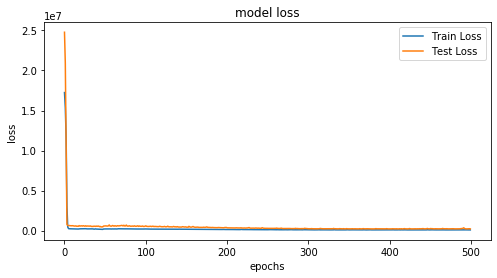

In [65]:
plt.figure(figsize=(8,4))
plt.plot(model2.history.history['loss'], label='Train Loss')
plt.plot(model2.history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();